install thresholder package for binary cutoff threshold methods


In [ ]:
!pip install git+https://github.com/nicholaslaw/roc-optimal-cutoff

  Cloning https://github.com/nicholaslaw/roc-optimal-cutoff to /tmp/pip-req-build-l7e6ey_s
  Running command git clone -q https://github.com/nicholaslaw/roc-optimal-cutoff /tmp/pip-req-build-l7e6ey_s
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 7.1 MB 25.1 MB/s 
     |████████████████████████████████| 10.1 MB 27.3 MB/s 
     |████████████████████████████████| 11.5 MB 16.5 MB/s 
  Created wheel for thresholder: filename=thresholder-1.0.2-py3-none-any.whl size=4157 sha256=07337603022ec33ec2971f26f463516781b572920a446f81220b670ae358f9eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-k_xuw13w/wheels/c5/19/b7/70c027dd573cb29c9ee9a3ec5d98dfe9be1ad8938d3b8a173c
Successfully built thresholder
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninst

supress SKLearn Warnings. 

In [ ]:
! pip install scikit-learn==0.23.1

     |████████████████████████████████| 6.8 MB 5.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thresholder 1.0.2 requires scikit-learn==0.22.2.post1, but you have scikit-learn 0.23.1 which is incompatible.
kapre 0.3.6 requires numpy>=1.18.5, but you have numpy 1.18.1 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.1 which is incompatible.


In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import required packages. 

pandas for CSV reading and Data Mangement

numpy for math and matrix computations

sklearn for Machine Learning, Feature Selection and Hyperparameter Tuning 

matlabplot for plotting

google.colab for file mangment

keras for Neural Networks

Statsmodel.api for the linear Regression statistics model

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import statsmodels.api as sm
from matplotlib import pyplot as plt
import matplotlib
from google.colab import drive,files
import imblearn
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, plot_roc_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
import pickle
import joblib
from scipy.stats import linregress
from scipy import interp
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from thresholder import Thresholder
from sklearn.impute import KNNImputer
from sklearn.utils import resample
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler 
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


we can see that the Dataset is highly imbalanced. with only 7% of Patients have "ai". this means that a ML algorithm designed to optimize for accuracy only might predict every sample as ai = 0(and get an "accuracy " of 93%).

drop patients with more than 25% missing features

we apply pd.to_numeric to ensure that no empty cells contain a space(and thus would be considered a string)

Mounted at /content/drive/


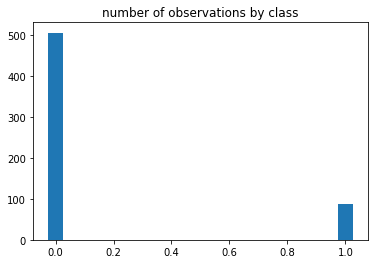

In [ ]:
drive.mount('/content/drive/', force_remount = True)
Data = pd.read_csv("/content/drive/My Drive/PANIC/USBv2.csv").apply(pd.to_numeric, errors='coerce').astype(float)
Data = pd.DataFrame(Data.dropna(thresh=0.25))

plt.bar([0.0, 1.0], [Data['ai'].value_counts()[0.0], Data['ai'].value_counts()[1.0]], width=0.05)
plt.title('number of observations by class')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Data.drop('ai', axis = 1),Data['ai'],test_size=0.2,random_state=0)
X_calb , y_calb = X_train, y_train

In [ ]:
train = pd.DataFrame(X_train, columns= Data.columns)
train["ai"] = y_train

test = pd.DataFrame(X_test, columns= Data.columns)
test["ai"] = y_test

pd.DataFrame(test.to_csv("Test.csv"))
pd.DataFrame(train.to_csv("Train.csv"))

#files.download("Train.csv")
#files.download("Test.csv")

Data.to_csv("Data.csv")
files.download("Data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Use a KNN Imputer to Impute missing Values


. Min_Max Scale all features




In [ ]:
imputer = KNNImputer()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())
X_test = (X_test-X_test.min())/(X_test.max()-X_test.min())

in order to prevent classifiers from predicting no 'ai' for all samples(and achieving 93% "accuracy"), we oversample ai=1 patients in the Training Data ONLY

the bootstrapper method does all the work. it takes in the data and the model, and trains the model using the specified parameter and evaluates it's perforamce. this is done a {n} times, with each training/test split being randomly generated

In [ ]:
X_calb , y_calb = X_train, y_train
X_train, y_train =  RandomOverSampler().fit_resample(X = X_train, y= y_train)

In [ ]:
rfe = RFE(RandomForestClassifier(random_state=5, n_jobs = 16) )
rfe.fit(X_train, y_train)

print(rfe.ranking_)
support = rfe.support_

RFE_features = []
for i in range(len(Data.columns)-1):
  if support[i] == True:
    RFE_features.append(Data.columns[i])

print(RFE_features)

X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)
X_calb = rfe.transform(X_calb)

[ 1  6  1  1  7  8  5 10  1  1  1  1  1  4  3  2  9  1  1 12 11]
['age', 'bmi', 'smoker', 'cci', 'asa', 'renal', 'albumin', 'hemoglobin', 'type', 'indication']


In [ ]:
def bootstrapper(data, estimator, param, n, label, Importance = False):
  X_train, X_test, X_calb, y_train, y_test1, y_calb = data
  auc = []
  auc2 = []
  acc = []
  recall = []
  precision = []
  spec = []
  brier = []
  calb_slope = []
  calb_intcp = []
  prob_true = []
  prob_predict = []
  tprs = []
  prob_trues = []
  prob_preds = []
  if Importance == True: 
    importance = []
  
  base_fpr = np.linspace(0, 1, 100)

  

  clf = GridSearchCV(estimator=estimator, param_grid=param, cv=RepeatedKFold())
  clf.fit(X_train, y_train)

  clb = CalibratedClassifierCV(clf.best_estimator_,cv= 'prefit')
  clb.fit(X_calb, y_calb)

  Thres = Thresholder()
  Thres.fit(clb.predict_proba(X_train), y_train, curve="roc",method= "euclidean")
  threshold = Thres.cutoffs[1]

  y_prob1 = clb.predict_proba(X_test)[:, 1]
  y_pred1 = clb.predict_proba(X_test)[:, 1] > threshold

  y_prob1_train = clb.predict_proba(X_train)[:, 1]
  y_pred1_train = clb.predict_proba(X_train)[:, 1] > threshold 

  rng = np.random.RandomState(0)
  for i in range(n):
    
    
    indices = rng.randint(0, len(y_pred1), len(y_pred1))
    if len(np.unique(y_test1.iloc[indices])) < 2:
      continue
    y_prob = y_prob1[indices]
    y_pred = y_pred1[indices]
    y_test = y_test1.iloc[indices]
    
    
    prob_true_temp, prob_predict_temp = calibration_curve(y_test, y_prob, n_bins = 5, strategy='quantile')
    slope, intercept, r_value, p_value, std_err = linregress(prob_predict_temp,prob_true_temp)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    if Importance == True: 
      importance.append(clb.base_estimator.feature_importances_)


    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, 'purple', alpha = 0.001)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

    prob_trues.append(prob_true_temp)
    prob_preds.append(prob_predict_temp)

    auc_temp = metrics.roc_auc_score(y_test, y_prob)
    auc2_temp = metrics.roc_auc_score(y_test, y_pred)
    acc_temp = metrics.accuracy_score(y_test, y_pred)
    recall_temp = metrics.recall_score(y_test, y_pred)
    precision_temp = metrics.precision_score(y_test, y_pred)
    specificity_temp = tn / (tn+fp)
    brier_temp = metrics.brier_score_loss(y_test, y_prob)
    calb_slope_temp = slope
    calb_intcp_temp = intercept

    auc.append(auc_temp)
    auc2.append(auc2_temp)
    acc.append(acc_temp)
    recall.append(recall_temp)
    precision.append(precision_temp)
    spec.append(specificity_temp)
    brier.append(brier_temp)
    calb_slope.append(calb_slope_temp)
    calb_intcp.append(calb_intcp_temp)
    

    

  
  if Importance == True: 
    means = np.array(importance).mean(axis = 0)
    lower = np.percentile(a= np.array(importance), q= 2.5, axis = 0)
    upper = np.percentile(a= np.array(importance), q= 97.5, axis = 0)

    for i, feature in enumerate(RFE_features):
      print(f'{feature},{np.round(means[i],2)}(95% CI: {np.round(lower[i],2)} - {np.round(upper[i],2)}),')


  prob_true2 = np.array(prob_trues).mean(axis = 0)
  prob_pred2 = np.array(prob_preds).mean(axis = 0)
  stds = 2*np.array(prob_preds).std(axis = 0)

  mean_tprs = np.array(tprs).mean(axis = 0)
  std = 2 * np.array(tprs).std(axis = 0)


  tprs_upper = np.minimum(mean_tprs + std, 1)
  tprs_lower = mean_tprs - std

  plt.plot(base_fpr, mean_tprs, 'purple', label = f'AUC = {np.round(np.mean(auc),2)}(95% CI:{np.round(np.percentile(auc,2.5),2)}-{np.round(np.percentile(auc,97.5),2)})')
  plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='plum', alpha=0.3)

  plt.plot([0, 1], [0, 1],'r--', label = 'Random(AUC = 0.5)')
  plt.title(f'ROC Curve for the {label} Classifier Across')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc="lower right")
  plt.axes().set_aspect('auto', 'datalim')
  plt.show()

  plt.plot(prob_true2, prob_pred2, 'purple', label = f'Slope = {np.round(np.mean(calb_slope),2)}(95% CI:{np.round(np.percentile(calb_slope,2.5),2)}-{np.round(np.percentile(calb_slope,97.5),2)})' + "\n" + f'Intercept= {np.round(np.mean(calb_intcp),2)}(95% CI:{np.round(np.percentile(calb_intcp,10),2)}-{np.round(np.percentile(calb_intcp,90),2)})')
  plt.title(f'Calibration Curve for the {label} Classifier')
  plt.ylabel('Observed Probability')
  plt.xlabel('Predicted Probability')
  plt.plot([0, 0.3], [0, 0.3],'r--', label = 'ideal')
  plt.legend(loc="lower right")
  plt.fill_between(prob_true2, prob_pred2 + stds, prob_pred2 - stds, color='plum', alpha = 0.3)
  plt.axes().set_aspect('auto', 'datalim')
  plt.show()



  print(f'FINAL')
  print(f'AUC = {np.round(np.mean(auc),2)}({np.round(np.percentile(auc,2.5),2)}-{np.round(np.percentile(auc,97.5),2)})')
  print(f'AUC-Classification = {np.round(np.mean(auc2),2)}({np.round(np.percentile(auc2,2.5),2)}-{np.round(np.percentile(auc2,97.5),2)})')
  print(f'Accuracy = {np.round(np.mean(acc),2)}({np.round(np.percentile(acc,2.5),2)}-{np.round(np.percentile(acc,97.5),2)})')
  print(f'Recall = {np.round(np.mean(recall),2)}({np.round(np.percentile(recall,2.5),2)}-{np.round(np.percentile(recall,97.5),2)})')
  print(f'Precision = {np.round(np.mean(precision),2)}({np.round(np.percentile(precision,2.5),2)}-{np.round(np.percentile(precision,97.5),2)})')
  print(f'Specificity = {np.round(np.mean(spec),2)}({np.round(np.percentile(spec,2.5),2)}-{np.round(np.percentile(spec,97.5),2)})')
  print(f'Brier = {np.round(np.mean(brier),2)}({np.round(np.percentile(brier,2.5),2)}-{np.round(np.percentile(brier,97.5),2)})')
  print(f'Calibration Slope = {np.round(np.mean(calb_slope),2)}({np.round(np.percentile(calb_slope,2.5),2)}-{np.round(np.percentile(calb_slope,97.5),2)})')
  print(f'Calibration Intercept = {np.round(np.mean(calb_intcp),2)}({np.round(np.percentile(calb_intcp,2.5),2)}-{np.round(np.percentile(calb_intcp,97.5),2)})')

  auc = []
  auc2 = []
  acc = []
  recall = []
  precision = []
  spec = []
  brier = []
  calb_slope = []
  calb_intcp = []
  prob_true = []
  prob_predict = []
  tprs = []
  prob_trues = []
  prob_preds = []
  if Importance == True: 
    importance = []
  
  base_fpr = np.linspace(0, 1, 100)


  for i in range(n):
    indices = rng.randint(0, len(y_pred1), len(y_pred1))
    if len(np.unique(y_test1.iloc[indices])) < 2:
      continue
    y_prob = y_prob1_train[indices]
    y_pred = y_pred1_train[indices]
    y_test = y_train.iloc[indices]
    
    
    prob_true_temp, prob_predict_temp = calibration_curve(y_test, y_prob, n_bins = 5, strategy='quantile')
    slope, intercept, r_value, p_value, std_err = linregress(prob_predict_temp,prob_true_temp)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    if Importance == True: 
      importance.append(clb.base_estimator.feature_importances_)


    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, 'purple', alpha = 0.001)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

    prob_trues.append(prob_true_temp)
    prob_preds.append(prob_predict_temp)

    auc_temp = metrics.roc_auc_score(y_test, y_prob)
    auc2_temp = metrics.roc_auc_score(y_test, y_pred)
    acc_temp = metrics.accuracy_score(y_test, y_pred)
    recall_temp = metrics.recall_score(y_test, y_pred)
    precision_temp = metrics.precision_score(y_test, y_pred)
    specificity_temp = tn / (tn+fp)
    brier_temp = metrics.brier_score_loss(y_test, y_prob)
    calb_slope_temp = slope
    calb_intcp_temp = intercept

    auc.append(auc_temp)
    auc2.append(auc2_temp)
    acc.append(acc_temp)
    recall.append(recall_temp)
    precision.append(precision_temp)
    spec.append(specificity_temp)
    brier.append(brier_temp)
    calb_slope.append(calb_slope_temp)
    calb_intcp.append(calb_intcp_temp)
    

  if Importance == True: 
    means = np.array(importance).mean(axis = 0)
    lower = np.percentile(a= np.array(importance), q= 2.5, axis = 0)
    upper = np.percentile(a= np.array(importance), q= 97.5, axis = 0)

    for i, feature in enumerate(RFE_features):
      print(f'{feature},{np.round(means[i],2)}(95% CI: {np.round(lower[i],2)} - {np.round(upper[i],2)}),')


  prob_true2 = np.array(prob_trues).mean(axis = 0)
  prob_pred2 = np.array(prob_preds).mean(axis = 0)
  stds = 2*np.array(prob_preds).std(axis = 0)

  mean_tprs = np.array(tprs).mean(axis = 0)
  std = 2 * np.array(tprs).std(axis = 0)


  tprs_upper = np.minimum(mean_tprs + std, 1)
  tprs_lower = mean_tprs - std

  plt.plot(base_fpr, mean_tprs, 'purple', label = f'AUC = {np.round(np.mean(auc),2)}(95% CI:{np.round(np.percentile(auc,2.5),2)}-{np.round(np.percentile(auc,97.5),2)})')
  plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='plum', alpha=0.3)

  plt.plot([0, 1], [0, 1],'r--', label = 'Random(AUC = 0.5)')
  plt.title(f'ROC Curve for the {label} Classifier Across')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc="lower right")
  plt.axes().set_aspect('auto', 'datalim')
  plt.show()

  plt.plot(prob_true2, prob_pred2, 'purple', label = f'Slope = {np.round(np.mean(calb_slope),2)}(95% CI:{np.round(np.percentile(calb_slope,2.5),2)}-{np.round(np.percentile(calb_slope,97.5),2)})' + "\n" + f'Intercept= {np.round(np.mean(calb_intcp),2)}(95% CI:{np.round(np.percentile(calb_intcp,10),2)}-{np.round(np.percentile(calb_intcp,90),2)})')
  plt.title(f'Calibration Curve for the {label} Classifier')
  plt.ylabel('Observed Probability')
  plt.xlabel('Predicted Probability')
  plt.plot([0, 0.3], [0, 0.3],'r--', label = 'ideal')
  plt.legend(loc="lower right")
  plt.fill_between(prob_true2, prob_pred2 + stds, prob_pred2 - stds, color='plum', alpha = 0.3)
  plt.axes().set_aspect('auto', 'datalim')
  plt.show()



  print(f'FINAL')
  print(f'AUC = {np.round(np.mean(auc),2)}({np.round(np.percentile(auc,2.5),2)}-{np.round(np.percentile(auc,97.5),2)})')
  print(f'AUC-Classification = {np.round(np.mean(auc2),2)}({np.round(np.percentile(auc2,2.5),2)}-{np.round(np.percentile(auc2,97.5),2)})')
  print(f'Accuracy = {np.round(np.mean(acc),2)}({np.round(np.percentile(acc,2.5),2)}-{np.round(np.percentile(acc,97.5),2)})')
  print(f'Recall = {np.round(np.mean(recall),2)}({np.round(np.percentile(recall,2.5),2)}-{np.round(np.percentile(recall,97.5),2)})')
  print(f'Precision = {np.round(np.mean(precision),2)}({np.round(np.percentile(precision,2.5),2)}-{np.round(np.percentile(precision,97.5),2)})')
  print(f'Specificity = {np.round(np.mean(spec),2)}({np.round(np.percentile(spec,2.5),2)}-{np.round(np.percentile(spec,97.5),2)})')
  print(f'Brier = {np.round(np.mean(brier),2)}({np.round(np.percentile(brier,2.5),2)}-{np.round(np.percentile(brier,97.5),2)})')
  print(f'Calibration Slope = {np.round(np.mean(calb_slope),2)}({np.round(np.percentile(calb_slope,2.5),2)}-{np.round(np.percentile(calb_slope,97.5),2)})')
  print(f'Calibration Intercept = {np.round(np.mean(calb_intcp),2)}({np.round(np.percentile(calb_intcp,2.5),2)}-{np.round(np.percentile(calb_intcp,97.5),2)})')



  return auc, acc, recall, precision, spec, brier, calb_slope, calb_intcp


In [ ]:
binput = [X_train, X_test, X_calb, y_train, y_test, y_calb]


**Logistic Regression**

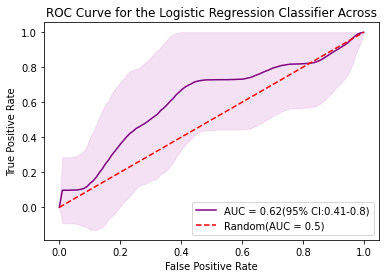

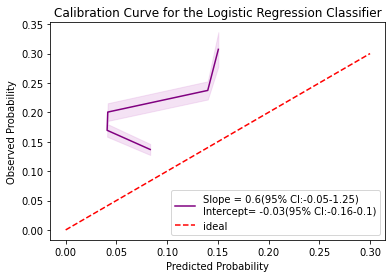

FINAL
AUC = 0.62(0.41-0.8)
AUC-Classification = 0.54(0.4-0.66)
Accuracy = 0.32(0.24-0.41)
Recall = 0.82(0.55-1.0)
Precision = 0.1(0.04-0.17)
Specificity = 0.27(0.19-0.35)
Brier = 0.1(0.07-0.13)
Calibration Slope = 0.6(-0.05-1.25)
Calibration Intercept = -0.03(-0.16-0.1)


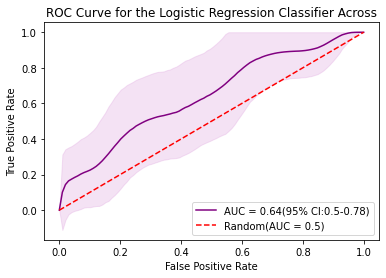

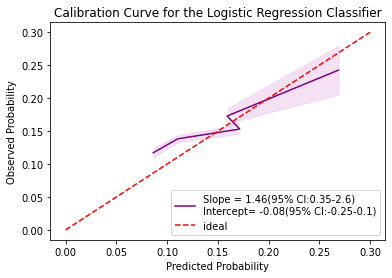

FINAL
AUC = 0.64(0.5-0.78)
AUC-Classification = 0.6(0.47-0.72)
Accuracy = 0.64(0.55-0.73)
Recall = 0.53(0.3-0.76)
Precision = 0.23(0.11-0.36)
Specificity = 0.66(0.57-0.75)
Brier = 0.13(0.09-0.18)
Calibration Slope = 1.46(0.35-2.6)
Calibration Intercept = -0.08(-0.25-0.1)


In [ ]:
params = {
    'C': [x*0.1 for x in range(1 , 20)],
    'max_iter':[400]
}


auc, acc, recall, precision, spec, brier, calb_slope, calb_intcp = bootstrapper(binput, LogisticRegression(n_jobs = 16), params, 1000, "Logistic Regression")

**Linear Support Vector Classifier**

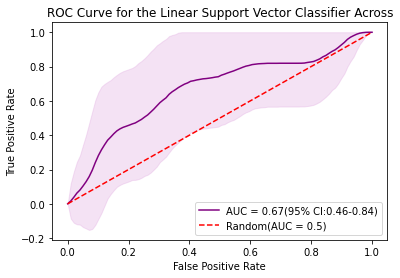

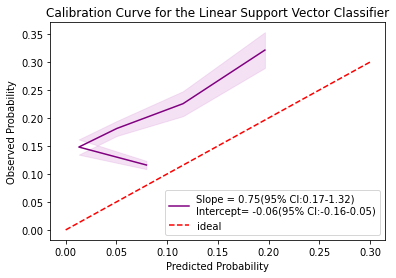

FINAL
AUC = 0.67(0.46-0.84)
AUC-Classification = 0.57(0.42-0.69)
Accuracy = 0.37(0.29-0.46)
Recall = 0.82(0.55-1.0)
Precision = 0.11(0.05-0.18)
Specificity = 0.33(0.24-0.42)
Brier = 0.09(0.07-0.12)
Calibration Slope = 0.75(0.17-1.32)
Calibration Intercept = -0.06(-0.16-0.05)


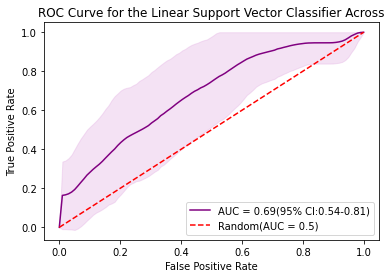

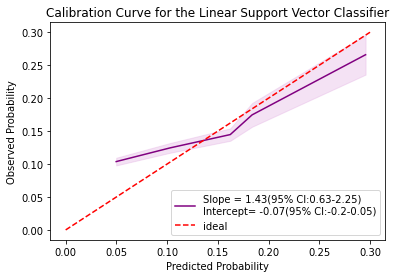

FINAL
AUC = 0.69(0.54-0.81)
AUC-Classification = 0.62(0.49-0.73)
Accuracy = 0.57(0.48-0.66)
Recall = 0.69(0.46-0.9)
Precision = 0.22(0.12-0.33)
Specificity = 0.54(0.45-0.64)
Brier = 0.13(0.08-0.17)
Calibration Slope = 1.43(0.63-2.25)
Calibration Intercept = -0.07(-0.2-0.05)


In [ ]:
params = {'C': [0.125, 0.25, 0.5, 1.0, 2.0]}
auc, acc, recall, precision, spec, brier, calb_slope, calb_intcp = bootstrapper(binput, SVC(probability = True), params, 1000, "Linear Support Vector")

**Naive Bayes**

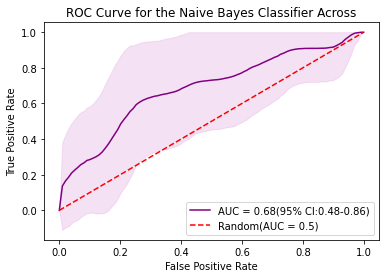

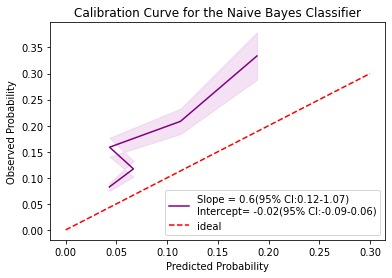

FINAL
AUC = 0.68(0.48-0.86)
AUC-Classification = 0.62(0.47-0.75)
Accuracy = 0.52(0.44-0.61)
Recall = 0.73(0.44-1.0)
Precision = 0.13(0.05-0.21)
Specificity = 0.5(0.41-0.59)
Brier = 0.09(0.06-0.12)
Calibration Slope = 0.6(0.12-1.07)
Calibration Intercept = -0.02(-0.09-0.06)


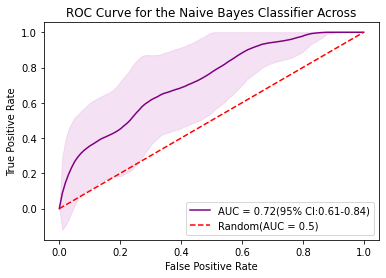

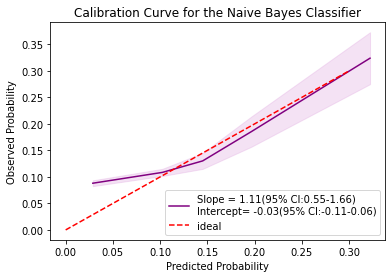

FINAL
AUC = 0.72(0.61-0.84)
AUC-Classification = 0.64(0.52-0.74)
Accuracy = 0.64(0.55-0.72)
Recall = 0.63(0.4-0.83)
Precision = 0.25(0.13-0.38)
Specificity = 0.64(0.54-0.73)
Brier = 0.12(0.08-0.17)
Calibration Slope = 1.11(0.55-1.66)
Calibration Intercept = -0.03(-0.11-0.06)


In [ ]:
params = {
    'var_smoothing' : [1e-11]
}
auc, acc, recall, precision, spec, brier, calb_slope, calb_intcp = bootstrapper(binput, GaussianNB(), params, 1000, "Naive Bayes")

**RandomForest Classifier**

age,0.11(95% CI: 0.11 - 0.11),
bmi,0.17(95% CI: 0.17 - 0.17),
smoker,0.12(95% CI: 0.12 - 0.12),
cci,0.15(95% CI: 0.15 - 0.15),
asa,0.1(95% CI: 0.1 - 0.1),
renal,0.05(95% CI: 0.05 - 0.05),
albumin,0.14(95% CI: 0.14 - 0.14),
hemoglobin,0.11(95% CI: 0.11 - 0.11),
type,0.04(95% CI: 0.04 - 0.04),
indication,0.02(95% CI: 0.02 - 0.02),


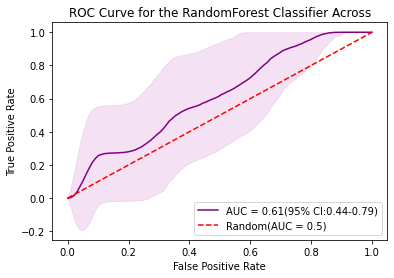

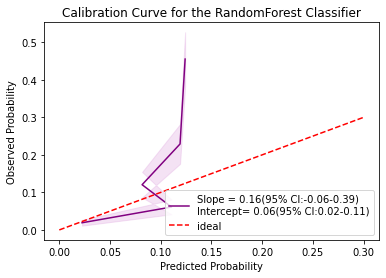

FINAL
AUC = 0.61(0.44-0.79)
AUC-Classification = 0.52(0.36-0.68)
Accuracy = 0.64(0.55-0.72)
Recall = 0.36(0.08-0.67)
Precision = 0.1(0.02-0.2)
Specificity = 0.67(0.58-0.76)
Brier = 0.11(0.08-0.15)
Calibration Slope = 0.16(-0.06-0.39)
Calibration Intercept = 0.06(0.02-0.11)
age,0.11(95% CI: 0.11 - 0.11),
bmi,0.17(95% CI: 0.17 - 0.17),
smoker,0.12(95% CI: 0.12 - 0.12),
cci,0.15(95% CI: 0.15 - 0.15),
asa,0.1(95% CI: 0.1 - 0.1),
renal,0.05(95% CI: 0.05 - 0.05),
albumin,0.14(95% CI: 0.14 - 0.14),
hemoglobin,0.11(95% CI: 0.11 - 0.11),
type,0.04(95% CI: 0.04 - 0.04),
indication,0.02(95% CI: 0.02 - 0.02),


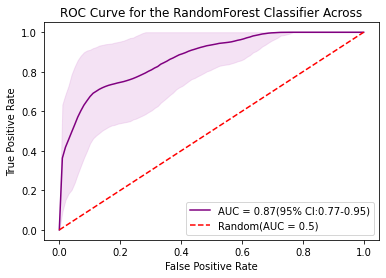

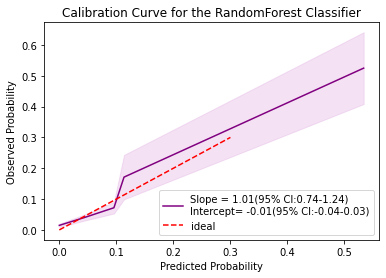

FINAL
AUC = 0.87(0.77-0.95)
AUC-Classification = 0.79(0.68-0.89)
Accuracy = 0.83(0.76-0.9)
Recall = 0.74(0.53-0.92)
Precision = 0.48(0.3-0.67)
Specificity = 0.85(0.78-0.91)
Brier = 0.09(0.05-0.12)
Calibration Slope = 1.01(0.74-1.24)
Calibration Intercept = -0.01(-0.04-0.03)


In [ ]:
params = {
    'n_estimators': [10, 100],

    'max_depth': [1,2,3],
    
    "criterion":['gini','entropy']}

auc, acc, recall, precision, spec, brier, calb_slope, calb_intcp = bootstrapper(binput, RandomForestClassifier(random_state=5, n_jobs = 16), params, 1000,"RandomForest", True)



**Extreme Gradient Boosting**

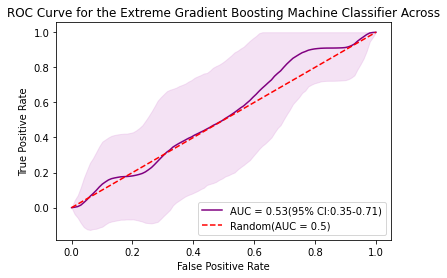

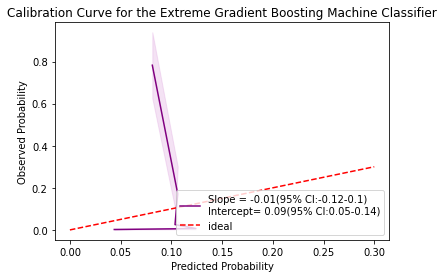

FINAL
AUC = 0.53(0.35-0.71)
AUC-Classification = 0.52(0.41-0.66)
Accuracy = 0.79(0.72-0.87)
Recall = 0.18(0.0-0.45)
Precision = 0.11(0.0-0.29)
Specificity = 0.85(0.79-0.92)
Brier = 0.2(0.14-0.26)
Calibration Slope = -0.01(-0.12-0.1)
Calibration Intercept = 0.09(0.05-0.14)


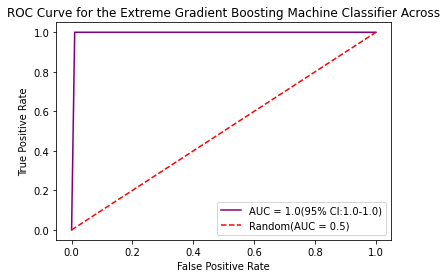

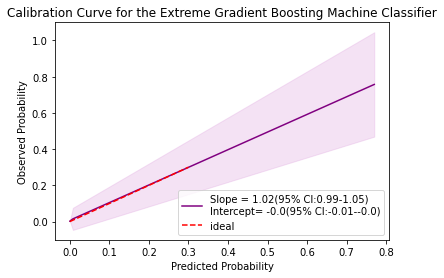

FINAL
AUC = 1.0(1.0-1.0)
AUC-Classification = 0.97(0.9-1.0)
Accuracy = 0.99(0.97-1.0)
Recall = 0.95(0.81-1.0)
Precision = 1.0(1.0-1.0)
Specificity = 1.0(1.0-1.0)
Brier = 0.0(0.0-0.0)
Calibration Slope = 1.02(0.99-1.05)
Calibration Intercept = -0.0(-0.01--0.0)


In [ ]:
params = {
         'max_depth': [x for x in range(5,11)],
          'min_child_weight': [x for x in range(3,7)],
          'subsample': [1.0],
          'colsample_bytree':[0.7, 0.8, 0.9, 1.0]
        }
auc, acc, recall, precision, spec, brier, calb_slope, calb_intcp = bootstrapper(binput, XGBClassifier(), params, 1000, "Extreme Gradient Boosting Machine")

**1- Hidden Layer Artificial neural network**

In [ ]:
def ann(l1,activation,lr) :
    model = Sequential()

    model.add(Dense(units=l1,input_dim=len(RFE_features),kernel_initializer='normal',activation=activation))
    model.add(Dense(units=1,kernel_initializer='normal',activation = "sigmoid"))
    optimizer = Adam(lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

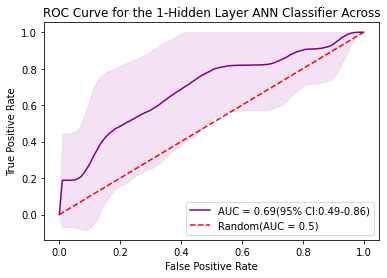

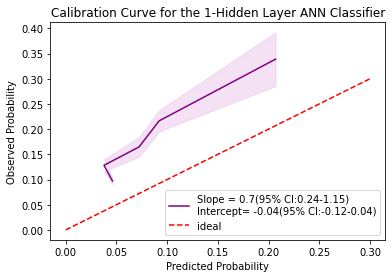

FINAL
AUC = 0.69(0.49-0.86)
AUC-Classification = 0.61(0.46-0.72)
Accuracy = 0.44(0.35-0.53)
Recall = 0.82(0.54-1.0)
Precision = 0.12(0.05-0.2)
Specificity = 0.4(0.31-0.49)
Brier = 0.09(0.06-0.12)
Calibration Slope = 0.7(0.24-1.15)
Calibration Intercept = -0.04(-0.12-0.04)


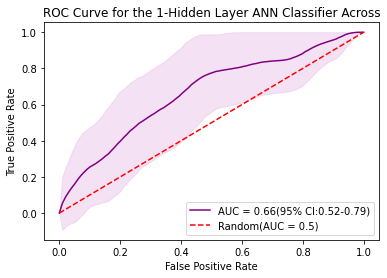

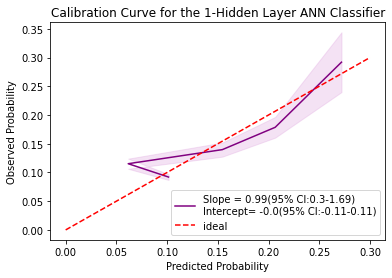

FINAL
AUC = 0.66(0.52-0.79)
AUC-Classification = 0.65(0.53-0.76)
Accuracy = 0.58(0.5-0.66)
Recall = 0.74(0.53-0.94)
Precision = 0.24(0.14-0.35)
Specificity = 0.55(0.46-0.64)
Brier = 0.13(0.09-0.17)
Calibration Slope = 0.99(0.3-1.69)
Calibration Intercept = -0.0(-0.11-0.11)


In [ ]:
params = {
    "l1" : [32,64,128,256],
    "activation" :['relu'],
    "lr" : [0.01],
    'verbose' : [0]
    }

ANN = KerasClassifier(build_fn=ann,batch_size=1,epochs=10)
ANN._estimator_type = "classifier"
auc, acc, recall, precision, spec, brier, calb_slope, calb_intcp = bootstrapper(binput, ANN, params, 1000, "1-Hidden Layer ANN")

**2- Hidden Layer Artificial neural network**

In [ ]:
def ann2(l1,l2,activation,lr) :
    model = Sequential()

    model.add(Dense(units=l1,input_dim=len(RFE_features),kernel_initializer='normal',activation=activation))
    model.add(Dense(units=l2,kernel_initializer='normal',activation=activation))
    model.add(Dense(units=1,kernel_initializer='normal',activation = "sigmoid"))
    optimizer = Adam(lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

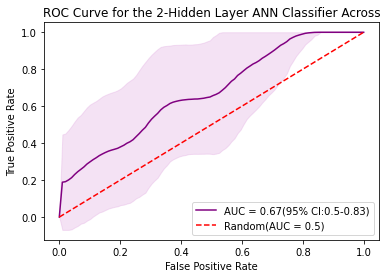

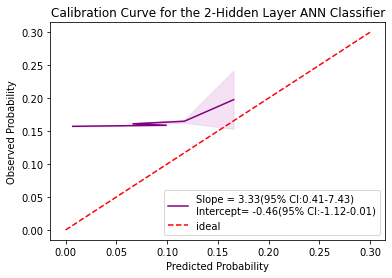

FINAL
AUC = 0.67(0.5-0.83)
AUC-Classification = 0.6(0.47-0.71)
Accuracy = 0.42(0.34-0.51)
Recall = 0.82(0.56-1.0)
Precision = 0.12(0.05-0.2)
Specificity = 0.38(0.29-0.47)
Brier = 0.08(0.05-0.12)
Calibration Slope = 3.33(0.41-7.43)
Calibration Intercept = -0.46(-1.12-0.01)


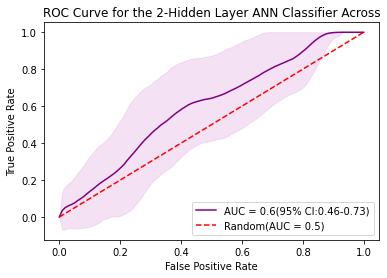

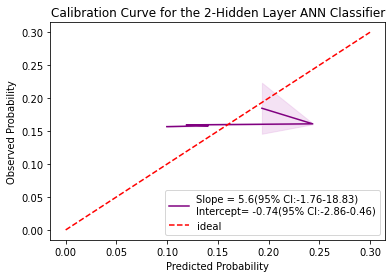

FINAL
AUC = 0.6(0.46-0.73)
AUC-Classification = 0.6(0.48-0.72)
Accuracy = 0.58(0.5-0.66)
Recall = 0.64(0.42-0.86)
Precision = 0.22(0.12-0.33)
Specificity = 0.57(0.48-0.67)
Brier = 0.14(0.09-0.19)
Calibration Slope = 5.6(-1.76-18.83)
Calibration Intercept = -0.74(-2.86-0.46)


In [ ]:
params = {
    "l1" : [32,64,128,256],
    "l2" : [32,64,128,256],
    "activation" :['relu'],
    "lr" : [0.01],
    'verbose' : [0]
    }

ANN2 = KerasClassifier(build_fn=ann2,batch_size=20,epochs=5)
ANN2._estimator_type = "classifier"
auc, acc, recall, precision, spec, brier, calb_slope, calb_intcp = bootstrapper(binput, ANN2, params, 1000, "2-Hidden Layer ANN")